In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import copy


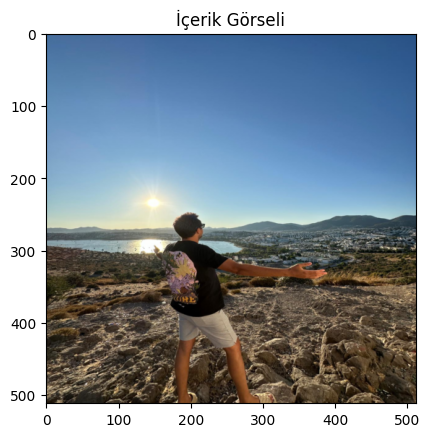

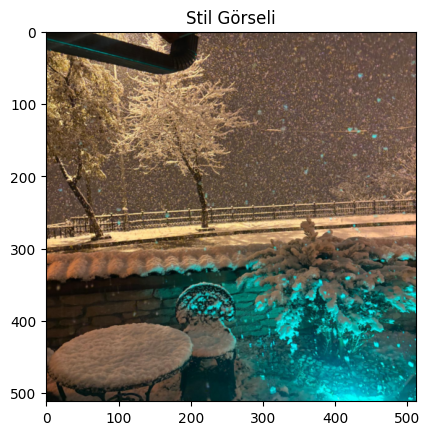

In [4]:

def image_loader(image_name):
    image = Image.open(image_name)
    loader = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()])
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


content_img = image_loader("content.jpg")
style_img = image_loader("style.jpg")


unloader = transforms.ToPILImage()

plt.ion()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(content_img, title='İçerik Görseli')

plt.figure()
imshow(style_img, title='Stil Görseli')


In [5]:

cnn = models.vgg19(pretrained=True).features.to(device).eval()


cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std


class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = 0

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input


def gram_matrix(input):
    batch_size, feature_maps, h, w = input.size()
    features = input.view(feature_maps, h * w)
    G = torch.mm(features, features.t())
    return G.div(feature_maps * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = 0

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.6MB/s]


In [6]:

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                style_img, content_img,
                                content_layers=content_layers,
                                style_layers=style_layers):
    cnn = copy.deepcopy(cnn)


    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)


    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


In [7]:

input_img = content_img.clone()




def show_image(tensor, title='Sonuç Görseli'):
    image = tensor.cpu().clone().squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    plt.title(title)
    plt.show()


def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):

    print('Stil aktarımı başlatılıyor...')
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_img, content_img)

    optimizer = optim.LBFGS([input_img.requires_grad_()])

    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:

                print(f"Adım {run[0]}:")
                print(f"Stil Kaybı : {style_score.item():.4f}  İçerik Kaybı : {content_score.item():.4f}")

            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img


Stil aktarımı başlatılıyor...
Adım 50:
Stil Kaybı : 96.7590  İçerik Kaybı : 11.0768
Adım 100:
Stil Kaybı : 37.2055  İçerik Kaybı : 12.7380
Adım 150:
Stil Kaybı : 11.7542  İçerik Kaybı : 12.8917
Adım 200:
Stil Kaybı : 5.9592  İçerik Kaybı : 11.2755
Adım 250:
Stil Kaybı : 3.9361  İçerik Kaybı : 10.0725
Adım 300:
Stil Kaybı : 2.7800  İçerik Kaybı : 9.3325


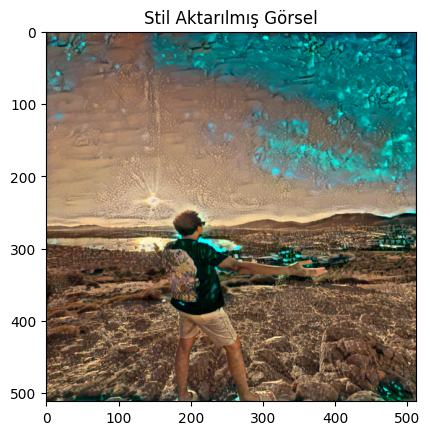

In [8]:

output = run_style_transfer(
    cnn,
    cnn_normalization_mean,
    cnn_normalization_std,
    content_img,
    style_img,
    input_img.clone(),
    num_steps=300,
    style_weight=1e6,
    content_weight=1
)


show_image(output, title='Stil Aktarılmış Görsel')


In [9]:
output_img = output.cpu().clone().squeeze(0)
output_img = transforms.ToPILImage()(output_img)
output_img.save("stil_aktarilmis_sonuc.jpg")